In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import seaborn as sns

from approaches_final import baseline, cluster_methods, oracle
from approaches_fair_individual_loss import ftc
from approaches_agenda import agenda

In [3]:
legend_fontsize = 14
title_fontsize = 18
label_fontsize = 16
ticks_fontsize = 14

In [4]:
db = pd.read_csv('data/rfw/rfw.csv')
dataset_name = 'rfw'
feature = 'facenet'
calibration_method = 'beta'
nbins = 25
n_clusters = 100

In [5]:
subgroups = {'ethnicity': ['African', 'Asian', 'Caucasian', 'Indian']}
sensitive_attributes = {'ethnicity': ['ethnicity', 'ethnicity']}
fold = 5

In [8]:
features = ['facenet-webface']

In [9]:
title_features = {
    'facenet':'FaceNet (VGGFace2)',
    'facenet-webface':'FaceNet (Webface)',
    'arcface': 'ArcFace'}

In [10]:
title_methods = {
    'naive': 'Baseline',
    'fsn': 'FSN [36]',
    'bmc': 'BMC (Ours)',
    'oracle': 'Oracle'
}

In [11]:
db_fold = {'cal': db[db['fold'] != fold], 'test': db[db['fold'] == fold]}

In [12]:
scores = {}
confidences = {}
for feature in features:
    scores[feature] = {}
    confidences[feature] = {}
ground_truth = {}
subgroup_scores = {}
for dataset in ['cal', 'test']:
    for feature in features:
        scores[feature][dataset] = np.array(db_fold[dataset][feature])
    ground_truth[dataset] = np.array(db_fold[dataset]['same'])
    subgroup_scores[dataset] = {}
    for att in subgroups.keys():
        subgroup_scores[dataset][att] = {}
        subgroup_scores[dataset][att]['left'] = np.array(db_fold[dataset][sensitive_attributes[att][0]])
        subgroup_scores[dataset][att]['right'] = np.array(db_fold[dataset][sensitive_attributes[att][1]])


In [13]:
for feature in features:
    confidences[feature]['baseline'] = baseline(scores[feature], ground_truth, nbins, calibration_method)
    confidences[feature]['oracle'] = oracle(scores[feature], ground_truth, subgroup_scores, subgroups, nbins, calibration_method)

In [14]:
for feature in features:
    _, _, confidences[feature]['bmc'], cluster_settings = cluster_methods(
                nbins,
                calibration_method,
                dataset_name,
                feature,
                fold,
                db_fold,
                100,
                False,
                0
            )

Statistics Cluster K = 100
Minimum number of pairs in clusters 228
Maximum number of pairs in clusters 488
Median number of pairs in clusters 330.0
Mean number of pairs in clusters 335.0


In [15]:
for feature in features:
    _, _, confidences[feature]['fsn'], cluster_settings = cluster_methods(
                nbins,
                calibration_method,
                dataset_name,
                feature,
                fold,
                db_fold,
                100,
                True,
                1e-3
            )

Statistics Cluster K = 100
Minimum number of pairs in clusters 228
Maximum number of pairs in clusters 488
Median number of pairs in clusters 330.0
Mean number of pairs in clusters 335.0


In [17]:
for feature in features:
    _, confidences[feature]['ftc'], _ = ftc(dataset_name, feature, db_fold, nbins, calibration_method)

Epoch 1
-------------------------------
loss: 0.347196  [    0/18819]
loss: 0.344042  [10000/18819]
Test Error: 
 Accuracy: 50.3%, Avg loss: 0.003501
FNR @ 0.1 FPR 0.92
Epoch 2
-------------------------------
loss: 0.347083  [    0/18819]
loss: 0.345859  [10000/18819]
Test Error: 
 Accuracy: 72.2%, Avg loss: 0.003493
FNR @ 0.1 FPR 0.93
Epoch 3
-------------------------------
loss: 0.344912  [    0/18819]
loss: 0.344924  [10000/18819]
Test Error: 
 Accuracy: 73.9%, Avg loss: 0.003497
FNR @ 0.1 FPR 0.92
Epoch 4
-------------------------------
loss: 0.345162  [    0/18819]
loss: 0.345836  [10000/18819]
Test Error: 
 Accuracy: 69.6%, Avg loss: 0.003489
FNR @ 0.1 FPR 0.90
Epoch 5
-------------------------------
loss: 0.344384  [    0/18819]
loss: 0.345453  [10000/18819]
Test Error: 
 Accuracy: 65.2%, Avg loss: 0.003487
FNR @ 0.1 FPR 0.94
Epoch 6
-------------------------------
loss: 0.344258  [    0/18819]
loss: 0.344050  [10000/18819]
Test Error: 
 Accuracy: 73.3%, Avg loss: 0.003492
FNR @

loss: 0.345000  [10000/18819]
Test Error: 
 Accuracy: 57.0%, Avg loss: 0.003493
FNR @ 0.1 FPR 0.97
Epoch 50
-------------------------------
loss: 0.345199  [    0/18819]
loss: 0.345084  [10000/18819]
Test Error: 
 Accuracy: 61.9%, Avg loss: 0.003499
FNR @ 0.1 FPR 0.95
Done!
Test Error: 
 Accuracy: 61.5%, Avg loss: 0.003476
FNR @ 0.1 FPR 0.93
Test Error: 
 Accuracy: 61.7%, Avg loss: 0.003499
FNR @ 0.1 FPR 0.93


In [20]:
for feature in features:
    _, confidences[feature]['agenda'], _, _, _ = agenda(dataset_name, feature, db_fold, nbins, calibration_method)

  0%|          | 0/50 [00:00<?, ?it/s]

STAGE 1


100%|██████████| 100/100 [07:39<00:00,  4.59s/it]


In [21]:
db_fold['test']['baseline'] = confidences['facenet-webface']['baseline']['test']
db_fold['test']['oracle'] = confidences['facenet-webface']['oracle']['test']['ethnicity']
db_fold['test']['fsn'] = confidences['facenet-webface']['fsn']['test']
db_fold['test']['ftc'] = confidences['facenet-webface']['ftc']['test']
db_fold['test']['agenda'] = confidences['facenet-webface']['agenda']['test']
db_fold['test']['bmc'] = confidences['facenet-webface']['bmc']['test']

In [22]:
legend_fontsize = 18
title_fontsize = 24
label_fontsize = 20
ticks_fontsize = 18

Baseline - African FPR = 7.563
Baseline - Asian FPR = 7.980
Baseline - Caucasian FPR = 0.509
Baseline - Indian FPR = 4.061
Baseline+Calibration - African FPR = 7.563
Baseline+Calibration - Asian FPR = 7.980
Baseline+Calibration - Caucasian FPR = 0.509
Baseline+Calibration - Indian FPR = 4.061
Oracle Calibration - African FPR = 5.546
Oracle Calibration - Asian FPR = 5.263
Oracle Calibration - Caucasian FPR = 5.263
Oracle Calibration - Indian FPR = 4.061
FairCal (Ours) - African FPR = 5.546
FairCal (Ours) - Asian FPR = 4.584
FairCal (Ours) - Caucasian FPR = 4.584
FairCal (Ours) - Indian FPR = 5.415


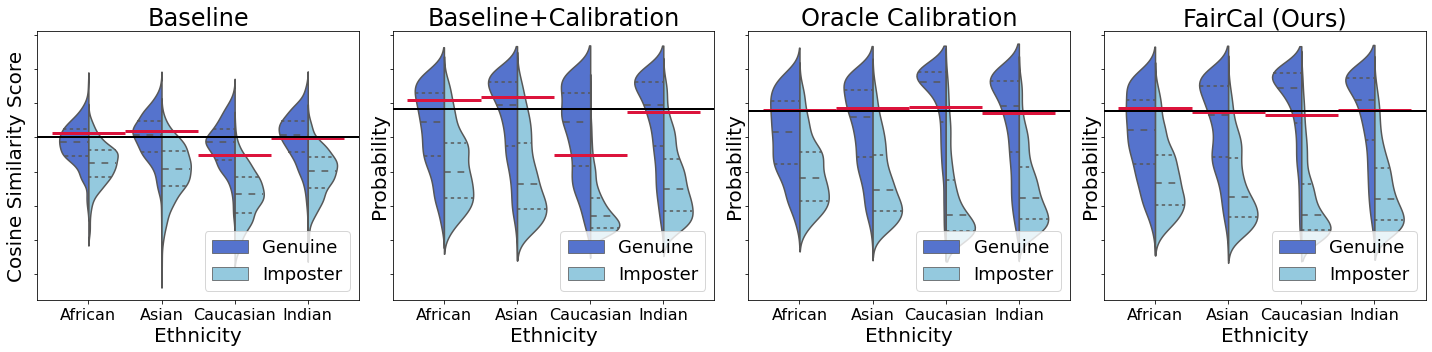

In [33]:
subgroups = ['African', 'Asian', 'Caucasian', 'Indian']
title_columns = ['Baseline', 'Baseline+Calibration', 'Oracle Calibration', 'FairCal (Ours)']
columns = ['facenet-webface','baseline','oracle', 'bmc']
fig, axes = plt.subplots(1,len(columns),figsize=(20,5), sharey=True)

# creating a dictionary with one specific color per group:
my_pal = {"Genuine": "royalblue", "Imposter": "skyblue"}
fpr_subgroup = {}
for i_aux, aux in enumerate(columns):
    sns.violinplot(
    x ='ethnicity',
    hue="pair",
    y=aux,
    split=True,
    data=db_fold['test'],
    scale="count",
    inner="quartile",
    ax = axes[i_aux],
    order=subgroups,
    palette=my_pal
)
    axes[i_aux].legend(loc = 'lower right', fontsize=legend_fontsize)
    axes[i_aux].set_xlabel('Ethnicity', fontsize=label_fontsize)
    axes[i_aux].set_title(title_columns[i_aux], fontsize=title_fontsize)
    if i_aux == 0:
        axes[i_aux].set_ylabel('Cosine Similarity Score', fontsize=label_fontsize)
    else:
        axes[i_aux].set_ylabel('Probability', fontsize=label_fontsize)
    labels = [item.get_text() for item in axes[i_aux].get_yticklabels()]
    empty_string_labels = ['']*len(labels)
    axes[i_aux].set_yticklabels(empty_string_labels)

    axes[i_aux].tick_params(axis='x', labelsize=ticks_fontsize-2)

    global_fpr,global_tpr,global_thr = sklearn.metrics.roc_curve(
            y_true = ground_truth['test'],
            y_score = db_fold['test'][aux],
            drop_intermediate=False,
            pos_label = True)
    
    axes[i_aux].axhline(global_thr[np.argmin(np.abs(global_fpr-0.05))],
                    ls='-',
                    linewidth=2,
                    alpha = 1,
                    c='black')
    fpr_subgroup[aux] = {}
    for j, subgroup in enumerate(subgroups):
        select = subgroup_scores['test']['ethnicity']['left'] == subgroup
        fpr,tpr,thr = sklearn.metrics.roc_curve(
            y_true = ground_truth['test'][select],
            y_score = db_fold['test'][aux][select],
            drop_intermediate=False,
            pos_label = True)
        axes[i_aux].hlines(y = thr[np.argmin(np.abs(fpr-0.05))],
                       ls='-',
                       color='crimson',
                       linewidth=3,
                       xmin =j-0.5,
                       xmax = j+1-0.5)
        fpr_subgroup[aux][j] = 100*fpr[np.argmin(np.abs(thr-np.interp(0.05,global_fpr,global_thr)))]
        print("%s - %s FPR = %1.3f"%(title_columns[i_aux], subgroup, fpr_subgroup[aux][j]))
fig.tight_layout()
plt.savefig('figs_iclr/facenet-webface_score_distributions_fpr_thresholds.png', bbox_inches='tight')

Baseline African - 7.6
Baseline Asian - 8.0
Baseline Indian - 4.1
Baseline Caucasian - 0.5
AGENDA African - 4.7
AGENDA Asian - 6.8
AGENDA Indian - 7.8
AGENDA Caucasian - 0.7
FTC African - 8.2
FTC Asian - 7.8
FTC Indian - 3.2
FTC Caucasian - 0.7
FSN African - 6.7
FSN Asian - 3.7
FSN Indian - 5.6
FSN Caucasian - 3.9
FairCal (Ours) African - 5.5
FairCal (Ours) Asian - 4.6
FairCal (Ours) Indian - 5.4
FairCal (Ours) Caucasian - 4.6


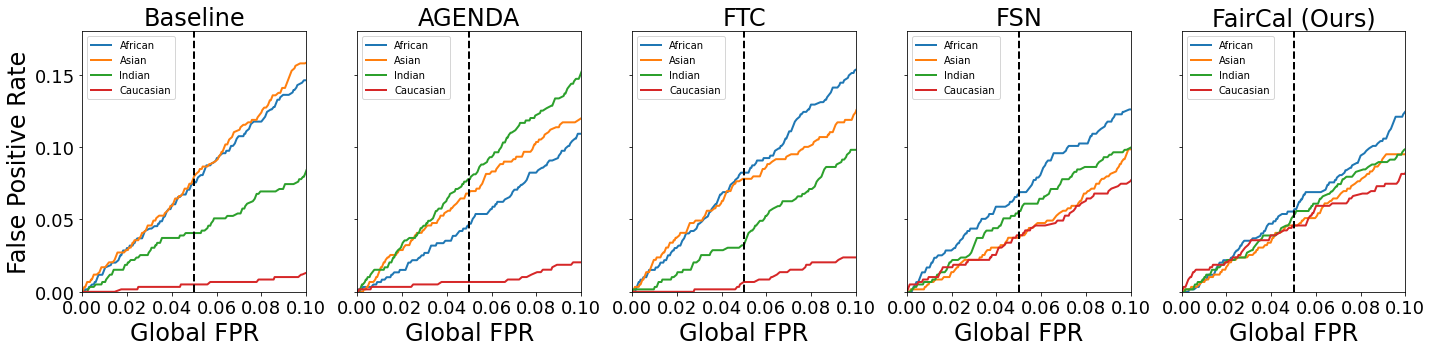

In [32]:

feature = 'facenet-webface'
metrics = {'aad': {}, 'mad': {}, 'std': {}}
subgroups = ['African', 'Asian', 'Indian', 'Caucasian']
title_columns = ['Baseline', 'AGENDA','FTC', 'FSN', 'FairCal (Ours)']
columns = ['facenet-webface','agenda', 'ftc', 'fsn','bmc']
fig, axes = plt.subplots(1,len(columns),figsize=(20,5), sharey=True)
for i_aux,aux in enumerate(columns):
    global_fpr,global_tpr,global_thr = sklearn.metrics.roc_curve(
            y_true = ground_truth['test'],
            y_score = db_fold['test'][aux],
            drop_intermediate=False,
            pos_label = True)
    fpr_subgroup[aux] = np.zeros(len(subgroups))
    for j, subgroup in enumerate(subgroups):
        select = subgroup_scores['test']['ethnicity']['left'] == subgroup
        fpr,tpr,thr = sklearn.metrics.roc_curve(
            y_true = ground_truth['test'][select],
            y_score = db_fold['test'][aux][select],
            drop_intermediate=False,
            pos_label = True)
        axes[i_aux].plot(np.interp(thr,global_thr[::-1],global_fpr[::-1]),fpr, linewidth=2)
        fpr_subgroup[aux][j] = 100*fpr[np.argmin(np.abs(thr-np.interp(0.05,global_fpr,global_thr)))]
        print('%s %s - %1.1f'%(title_columns[i_aux],subgroup, fpr_subgroup[aux][j]))
    metrics['aad'][aux] = np.mean(np.abs(fpr_subgroup[aux]-np.mean(fpr_subgroup[aux])))
    metrics['mad'][aux] = np.max(np.abs(fpr_subgroup[aux]-np.mean(fpr_subgroup[aux])))
    metrics['std'][aux] = np.std(fpr_subgroup[aux])
    # print('AAD = %1.2f'%metrics['aad']['bmc'])
    # print('MAD = %1.2f'%metrics['mad']['bmc'])
    # print('STD = %1.2f'%metrics['std']['bmc'])
    axes[i_aux].plot([0.05, 0.05],[0,1],'--k',linewidth=2)
    axes[i_aux].legend(subgroups,loc = 'upper left')
    axes[i_aux].set_xticks([0,0.02,0.04,0.06,0.08,0.1])
    axes[i_aux].set_xlim(0,0.1)
    axes[i_aux].set_ylim(0,0.18)
    axes[i_aux].set_title(title_columns[i_aux], fontsize=title_fontsize)
    axes[i_aux].set_xlabel('Global FPR', fontsize=title_fontsize)
    if i_aux == 0:
        axes[i_aux].set_ylabel('False Positive Rate', fontsize=title_fontsize)
    axes[i_aux].tick_params(axis='both', which='major', labelsize=ticks_fontsize)
fig.tight_layout()
plt.savefig('figs_iclr/facenet-webface_thr_vs_fpr.png', bbox_inches='tight')